### Прогноз размещения на площадке (отрасли + регионы закупок) 

In [7]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

In [8]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
#Немоного изменим параметры вывода графиков
rcParams['figure.figsize'] = 18,10

In [9]:
data = pd.read_excel('РегионыМесяца.xlsx')
data.head()

,RegCode,Регион,M1,M2,M3,M4,M5,M6,M7,M8,...,M27,M28,M29,M30,M31,M32,M33,M34,M35,M36
0,1,Адыгея,0,0,0,1,0,0,0,1,...,0,0,0,0,0,8,2,0,0,0
1,4,Алтай,34,218,210,195,256,263,265,268,...,305,350,350,348,199,370,205,0,0,0
2,22,Алтайский,120,997,1333,1369,1484,1832,1146,1280,...,1292,1444,1643,1911,1125,1552,1026,0,0,0
3,28,Амурская,179,638,464,381,625,633,603,666,...,554,700,727,733,566,621,346,0,0,0
4,29,Архангельская,20,33,22,10,19,26,25,36,...,55,88,101,72,77,125,30,0,0,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 38 columns):
RegCode    84 non-null int64
Регион     84 non-null object
M1         84 non-null int64
M2         84 non-null int64
M3         84 non-null int64
M4         84 non-null int64
M5         84 non-null int64
M6         84 non-null int64
M7         84 non-null int64
M8         84 non-null int64
M9         84 non-null int64
M10        84 non-null int64
M11        84 non-null int64
M12        84 non-null int64
M13        84 non-null int64
M14        84 non-null int64
M15        84 non-null int64
M16        84 non-null int64
M17        84 non-null int64
M18        84 non-null int64
M19        84 non-null int64
M20        84 non-null int64
M21        84 non-null int64
M22        84 non-null int64
M23        84 non-null int64
M24        84 non-null int64
M25        84 non-null int64
M26        84 non-null int64
M27        84 non-null int64
M28        84 non-null int64
M29        84 non-null int

In [11]:
columns=['Регион']
data.drop(columns, axis=1, inplace=True)

In [12]:
melt = data.melt(id_vars='RegCode', var_name='Month', value_name='Proc')

melt['Month'] = melt['Month'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['RegCode', 'Month'])
melt.head()

,RegCode,Month,Proc
0,1,1,0
84,1,2,0
168,1,3,0
252,1,4,1
336,1,5,0


In [13]:
melt2 =  melt.copy()
melt2['Last_Month_Proc'] = melt2.groupby(['RegCode'])['Proc'].shift()
melt2['Last_Month_Diff'] = melt2.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt2 = melt2.dropna()
melt2.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff
168,1,3,0,0.0,0.0
252,1,4,1,0.0,0.0
336,1,5,0,1.0,1.0
420,1,6,0,0.0,-1.0
504,1,7,0,0.0,0.0


In [14]:
melt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2856 entries, 168 to 3003
Data columns (total 5 columns):
RegCode            2856 non-null int64
Month              2856 non-null int32
Proc               2856 non-null int64
Last_Month_Proc    2856 non-null float64
Last_Month_Diff    2856 non-null float64
dtypes: float64(2), int32(1), int64(2)
memory usage: 122.7 KB


In [15]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [16]:
import copy

In [17]:
procedures = []
for Month in range(0,30):
    val=melt2[melt2['Month'] == Month]
    total=sum(val['Proc'])
    procedures.append(total)

In [18]:
%%time
mean_errorB = []
total_errorB = []
ProcB = copy.copy(procedures)
predict_ProcB = copy.copy(procedures)
for Month in range(30,33):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]
    yts=val['Proc']
    
    p = val['Last_Month_Proc'].values
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorB.append(error)
    total_errorB.append(abs_error)
    ProcB.append(total_yts)
    predict_ProcB.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error = %.5f' % np.mean(total_errorB))

Month 30 - Error 0.31365, Real Total 44141.0 - Predict Total 43152.0, Abs Error 989.0
Month 31 - Error 0.52830, Real Total 32367.0 - Predict Total 44141.0, Abs Error 11774.0
Month 32 - Error 0.52501, Real Total 40749.0 - Predict Total 32367.0, Abs Error 8382.0
Mean Error = 0.45565
Mean Abs Error = 7048.33333
Wall time: 11 ms


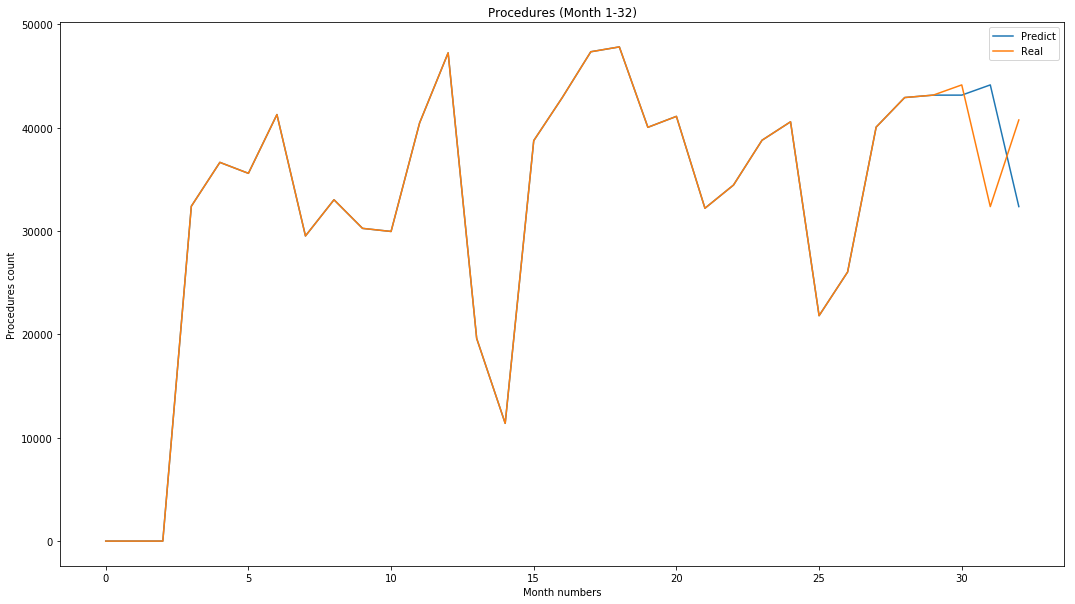

In [19]:

plt.plot(predict_ProcB)
plt.plot(ProcB)
plt.title('Procedures (Month 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

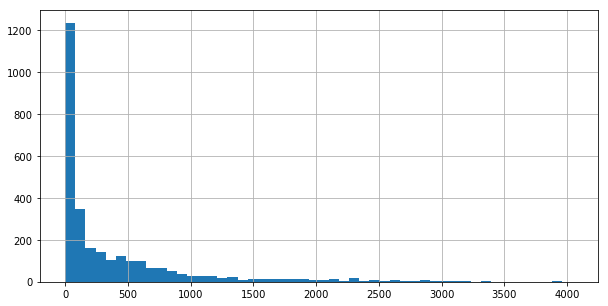

In [20]:
melt2['Proc'].hist(bins=50, figsize=(10,5))

In [21]:
%%time
mean_error2 = []
total_error2 = []
Proc2 = copy.copy(procedures)
predict_Proc2 = copy.copy(procedures)
for Month in range(30,33):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_error2.append(error)
    total_error2.append(abs_error)
    Proc2.append(total_yts)
    predict_Proc2.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_error2))
print('Mean Abs Error = %.5f' % np.mean(total_error2))

Month 30 - Error 0.76107, Real Total 44141.0 - Predict Total 43155.8, Abs Error 985.2
Month 31 - Error 1.00535, Real Total 32367.0 - Predict Total 44156.4, Abs Error 11789.4
Month 32 - Error 0.67569, Real Total 40749.0 - Predict Total 32802.3, Abs Error 7946.7
Mean Error = 0.81404
Mean Abs Error = 6907.10937
Wall time: 29.9 ms


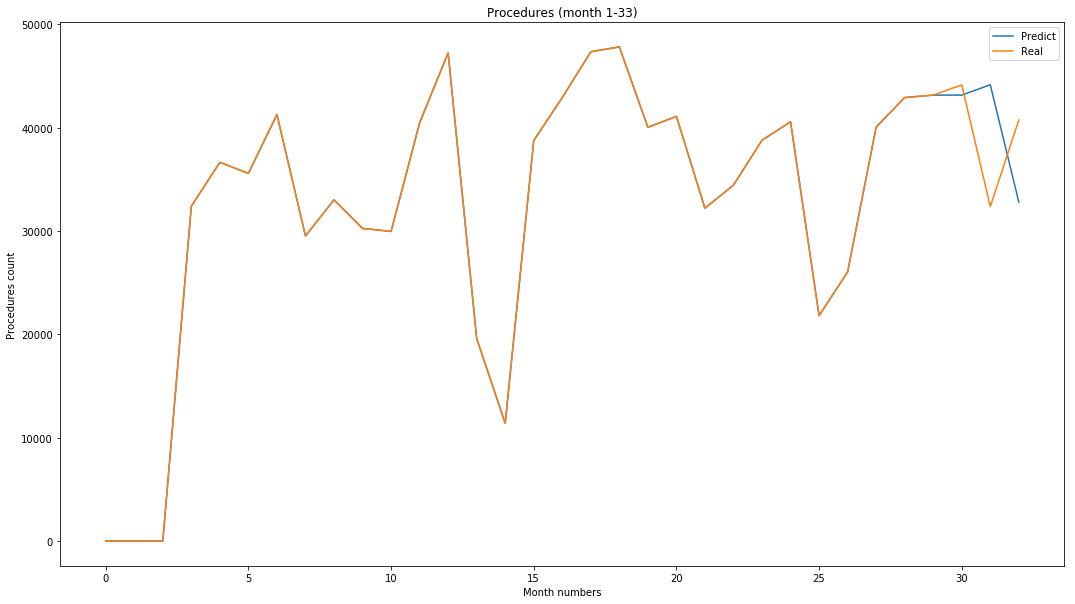

In [22]:

plt.plot(predict_Proc2)
plt.plot(Proc2)
plt.title('Procedures (month 1-33)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [23]:
%%time
mean_errorRF2 = []
total_errorRF2 = []
ProcRF2 = copy.copy(procedures)
predict_ProcRF2 = copy.copy(procedures)
for Month in range(30,33):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF2.append(error)
    total_errorRF2.append(abs_error)
    ProcRF2.append(total_yts)
    predict_ProcRF2.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF2))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF2))

Month 30 - Error 0.34651, Real Total 44141.0 - Predict Total 42600.7, Abs Error 1540.3
Month 31 - Error 0.59280, Real Total 32367.0 - Predict Total 43385.7, Abs Error 11018.7
Month 32 - Error 0.46363, Real Total 40749.0 - Predict Total 36261.5, Abs Error 4487.5
Mean Error = 0.46765
Mean Abs Error = 5682.18267
Wall time: 7.17 s


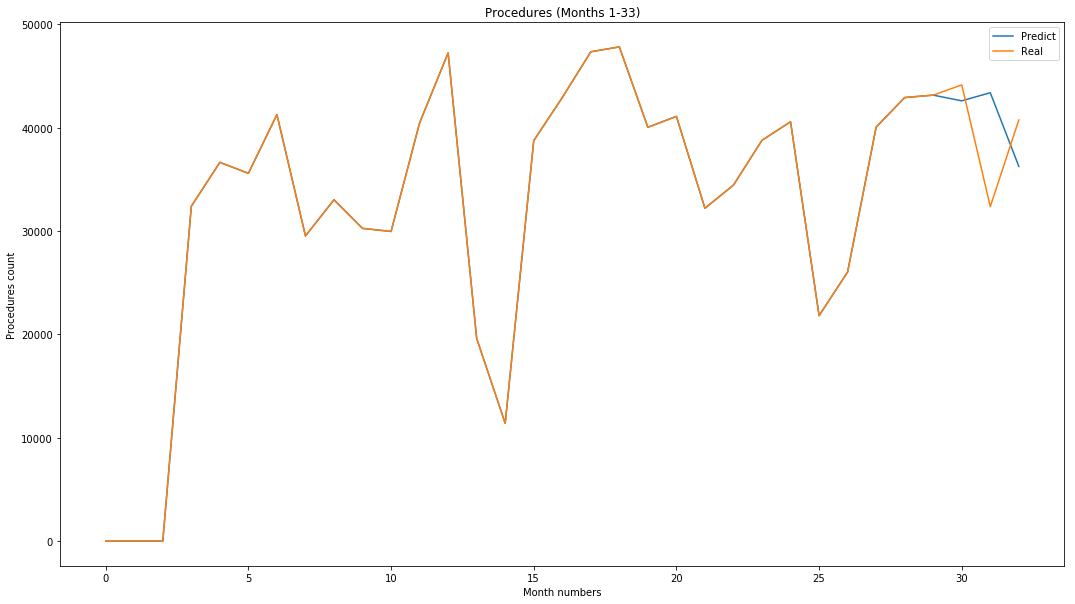

In [24]:

plt.plot(predict_ProcRF2)
#plt.plot(ProcRF2)
plt.plot(ProcB)
plt.title('Procedures (Months 1-33)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [25]:
melt3 = melt.copy()
melt3['Last_Month_Proc'] = melt3.groupby(['RegCode'])['Proc'].shift()
melt3['Last_Month_Diff'] = melt3.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt3['Last-1_Month_Proc'] = melt3.groupby(['RegCode'])['Proc'].shift(2)
melt3['Last-1_Month_Diff'] = melt3.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt3 = melt3.dropna()
melt3.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff
252,1,4,1,0.0,0.0,0.0,0.0
336,1,5,0,1.0,1.0,0.0,0.0
420,1,6,0,0.0,-1.0,1.0,1.0
504,1,7,0,0.0,0.0,0.0,-1.0
588,1,8,1,0.0,0.0,0.0,0.0


In [26]:
%%time
mean_errorRF3 = []
total_errorRF3 = []
ProcRF3 = copy.copy(procedures)
predict_ProcRF3 = copy.copy(procedures)
for Month in range(30,33):
    train = melt3[melt3['Month'] < Month]
    val = melt3[melt3['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF3.append(error)
    total_errorRF3.append(abs_error)
    ProcRF3.append(total_yts)
    predict_ProcRF3.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF3))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF3))

Month 30 - Error 0.32393, Real Total 44141.0 - Predict Total 42198.4, Abs Error 1942.6
Month 31 - Error 0.58664, Real Total 32367.0 - Predict Total 42674.8, Abs Error 10307.8
Month 32 - Error 0.49360, Real Total 40749.0 - Predict Total 34629.7, Abs Error 6119.3
Mean Error = 0.46806
Mean Abs Error = 6123.24067
Wall time: 7.98 s


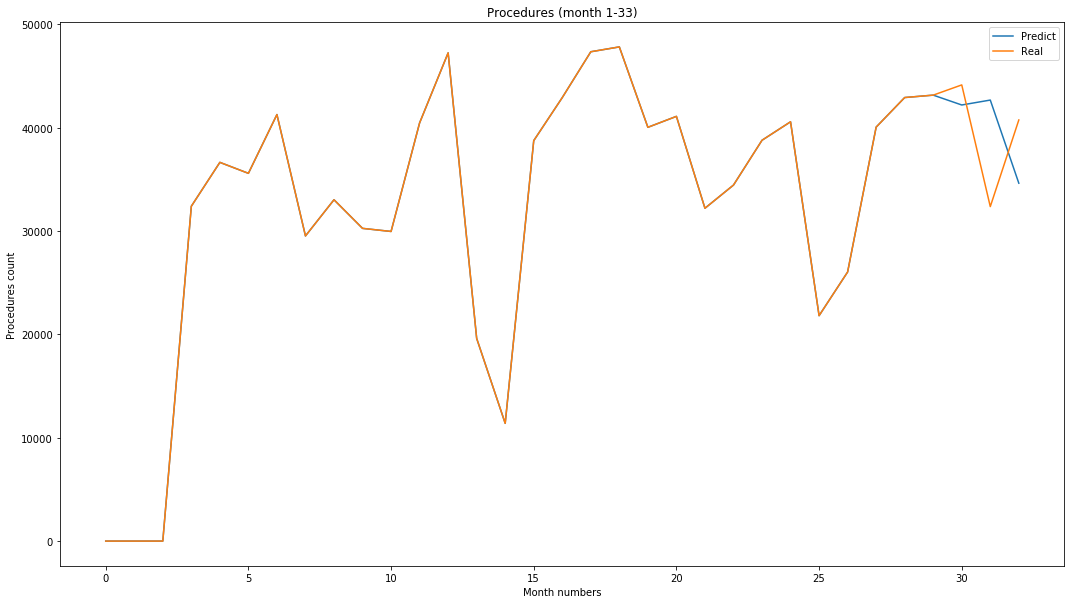

In [27]:

plt.plot(predict_ProcRF3)
plt.plot(ProcRF3)
plt.title('Procedures (month 1-33)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [28]:
melt4 = melt.copy()
melt4['Last_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift()
melt4['Last_Month_Diff'] = melt4.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt4['Last-1_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift(2)
melt4['Last-1_Month_Diff'] = melt4.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt4['Last-2_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift(3)
melt4['Last-2_Month_Diff'] = melt4.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt4 = melt4.dropna()
melt4.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff,Last-2_Month_Proc,Last-2_Month_Diff
336,1,5,0,1.0,1.0,0.0,0.0,0.0,0.0
420,1,6,0,0.0,-1.0,1.0,1.0,0.0,0.0
504,1,7,0,0.0,0.0,0.0,-1.0,1.0,1.0
588,1,8,1,0.0,0.0,0.0,0.0,0.0,-1.0
672,1,9,1,1.0,1.0,0.0,0.0,0.0,0.0


In [29]:
%%time
mean_errorRF4 = []
total_errorRF4 = []
ProcRF4 = copy.copy(procedures)
predict_ProcRF4 = copy.copy(procedures)
for Month in range(30,33):
    train = melt4[melt4['Month'] < Month]
    val = melt4[melt4['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF4.append(error)
    total_errorRF4.append(abs_error)
    ProcRF4.append(total_yts)
    predict_ProcRF4.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF4))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF4))

Month 30 - Error 0.30394, Real Total 44141.0 - Predict Total 41491.7, Abs Error 2649.3
Month 31 - Error 0.59793, Real Total 32367.0 - Predict Total 42357.3, Abs Error 9990.3
Month 32 - Error 0.50376, Real Total 40749.0 - Predict Total 34701.8, Abs Error 6047.2
Mean Error = 0.46855
Mean Abs Error = 6228.93967
Wall time: 9.32 s


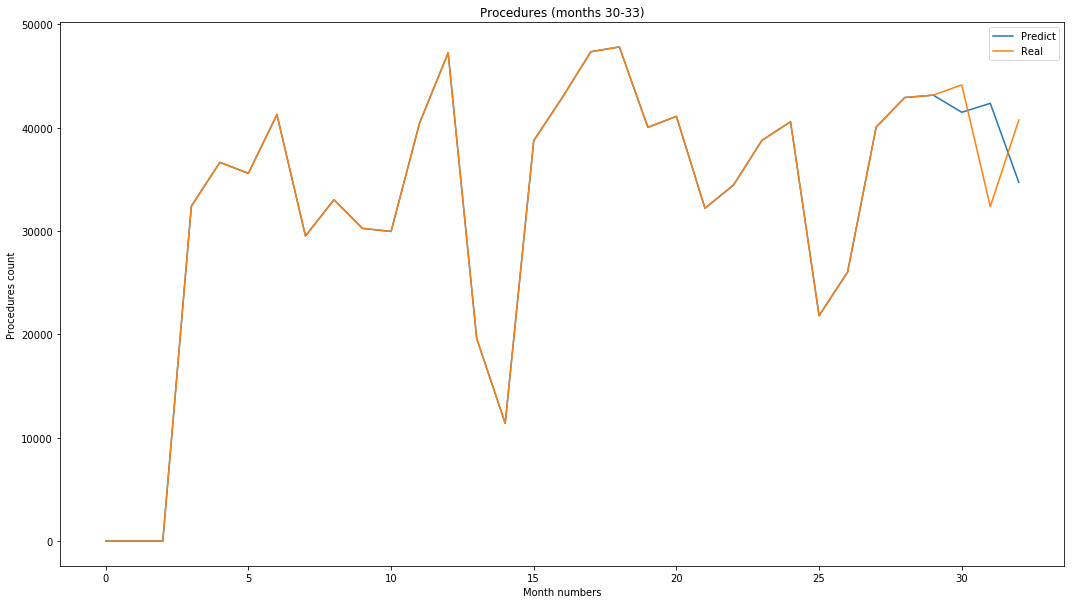

In [30]:

plt.plot(predict_ProcRF4)
plt.plot(ProcRF4)
plt.title('Procedures (months 30-33)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [31]:
%%time
mean_errorGB4 = []
total_errorGB4 = []
ProcGB4 = copy.copy(procedures)
predict_ProcGB4 = copy.copy(procedures)
for Month in range(30,33):
    train = melt4[melt4['Month'] < Month]
    val = melt4[melt4['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    #print('Month %d - Error %.5f' % (Month, error))
    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorGB4.append(error)
    total_errorGB4.append(abs_error)
    ProcGB4.append(total_yts)
    predict_ProcGB4.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorGB4))
print('Mean Abs Error = %.5f' % np.mean(total_errorGB4))

Month 30 - Error 0.33115, Real Total 44141.0 - Predict Total 43978.5, Abs Error 162.5
Month 31 - Error 0.60320, Real Total 32367.0 - Predict Total 44628.6, Abs Error 12261.6
Month 32 - Error 0.57268, Real Total 40749.0 - Predict Total 30449.3, Abs Error 10299.7
Mean Error = 0.50235
Mean Abs Error = 7574.58783
Wall time: 2.51 s


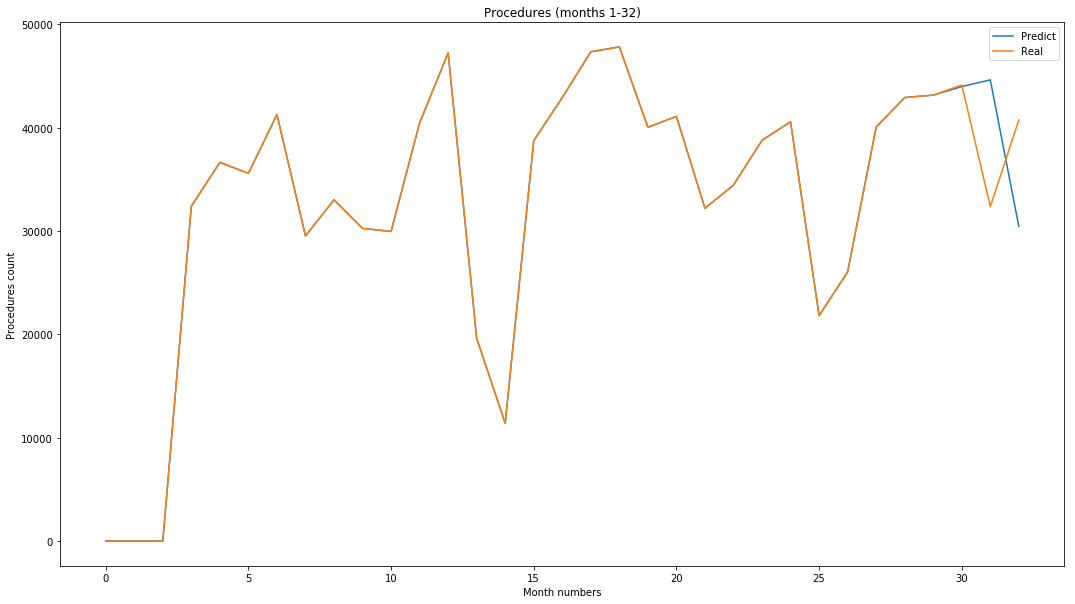

In [32]:

plt.plot(predict_ProcGB4)
plt.plot(ProcGB4)
plt.title('Procedures (months 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [33]:
%%time
melt12 = melt.copy()
melt12['Last_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift()
melt12['Last_Month_Diff'] = melt12.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt12['Last-1_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(2)
melt12['Last-1_Month_Diff'] = melt12.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt12['Last-2_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-2_Month_Diff'] = melt12.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt12['Last-3_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-3_Month_Diff'] = melt12.groupby(['RegCode'])['Last-3_Month_Proc'].diff()
melt12['Last-4_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-4_Month_Diff'] = melt12.groupby(['RegCode'])['Last-4_Month_Proc'].diff()
melt12['Last-5_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-5_Month_Diff'] = melt12.groupby(['RegCode'])['Last-5_Month_Proc'].diff()
melt12['Last-6_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-6_Month_Diff'] = melt12.groupby(['RegCode'])['Last-6_Month_Proc'].diff()
melt12['Last-7_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-7_Month_Diff'] = melt12.groupby(['RegCode'])['Last-7_Month_Proc'].diff()
melt12['Last-8_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-8_Month_Diff'] = melt12.groupby(['RegCode'])['Last-8_Month_Proc'].diff()
melt12['Last-9_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-9_Month_Diff'] = melt12.groupby(['RegCode'])['Last-9_Month_Proc'].diff()
melt12['Last-10_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-10_Month_Diff'] = melt12.groupby(['RegCode'])['Last-10_Month_Proc'].diff()
melt12['Last-11_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(2)
melt12['Last-11_Month_Diff'] = melt12.groupby(['RegCode'])['Last-11_Month_Proc'].diff()
melt12['Last-12_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-12_Month_Diff'] = melt12.groupby(['RegCode'])['Last-12_Month_Proc'].diff()
melt12 = melt12.dropna()
melt12.head()

Wall time: 178 ms


In [34]:
%%time
mean_errorRF12 = []
total_errorRF12 = []
ProcRF12 = copy.copy(procedures)
predict_ProcRF12 = copy.copy(procedures)
for Month in range(30, 33):
    train = melt12[melt12['Month'] < Month]
    val = melt12[melt12['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF12.append(error)
    total_errorRF12.append(abs_error)
    ProcRF12.append(total_yts)
    predict_ProcRF12.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF12))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF12))

Month 30 - Error 0.30362, Real Total 44141.0 - Predict Total 41480.0, Abs Error 2661.0
Month 31 - Error 0.60059, Real Total 32367.0 - Predict Total 42234.7, Abs Error 9867.7
Month 32 - Error 0.50396, Real Total 40749.0 - Predict Total 34686.0, Abs Error 6063.0
Mean Error = 0.46939
Mean Abs Error = 6197.24700
Wall time: 20.6 s


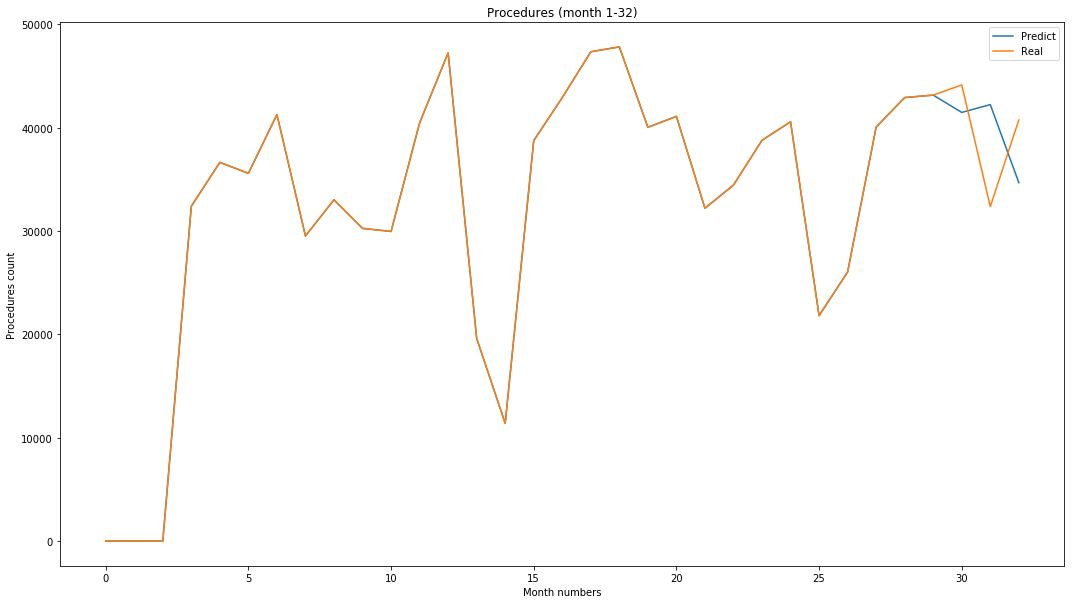

In [35]:

plt.plot(predict_ProcRF12)
plt.plot(ProcRF12)
plt.title('Procedures (month 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [36]:
%%time
mean_errorGB12 = []
total_errorGB12 = []
ProcGB12 = copy.copy(procedures)
predict_ProcGB12 = copy.copy(procedures)
for Month in range(30,33):
    train = melt12[melt12['Month'] < Month]
    val = melt12[melt12['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    
    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorGB12.append(error)
    total_errorGB12.append(abs_error)
    ProcGB12.append(total_yts)
    predict_ProcGB12.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorGB12))
print('Mean Abs Error = %.5f' % np.mean(total_errorGB12))

Month 30 - Error 0.33115, Real Total 44141.0 - Predict Total 43978.5, Abs Error 162.5
Month 31 - Error 0.60320, Real Total 32367.0 - Predict Total 44628.6, Abs Error 12261.6
Month 32 - Error 0.57268, Real Total 40749.0 - Predict Total 30449.3, Abs Error 10299.7
Mean Error = 0.50235
Mean Abs Error = 7574.58783
Wall time: 5.2 s


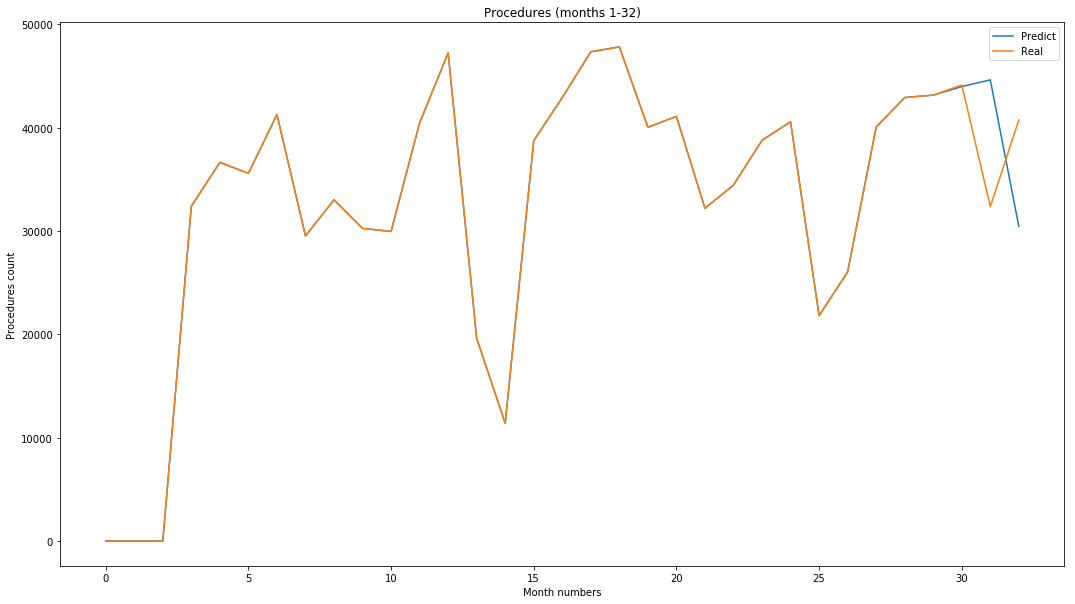

In [37]:

plt.plot(predict_ProcGB12)
plt.plot(ProcGB12)
plt.title('Procedures (months 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [38]:
%%time
mean_errorLR12 = []
total_errorLR12 = []
ProcLR12 = copy.copy(procedures)
predict_ProcLR12 = copy.copy(procedures)
for Month in range(30,33):
    train = melt12[melt12['Month'] < Month]
    val = melt12[melt12['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorLR12.append(error)
    total_errorLR12.append(abs_error)
    ProcLR12.append(total_yts)
    predict_ProcLR12.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorLR12))
print('Mean Abs Error = %.5f' % np.mean(total_errorLR12))

Month 30 - Error 0.68292, Real Total 44141.0 - Predict Total 41202.3, Abs Error 2938.7
Month 31 - Error 0.97132, Real Total 32367.0 - Predict Total 44948.8, Abs Error 12581.8
Month 32 - Error 0.60678, Real Total 40749.0 - Predict Total 34978.3, Abs Error 5770.7
Mean Error = 0.75367
Mean Abs Error = 7097.06960
Wall time: 22.9 ms


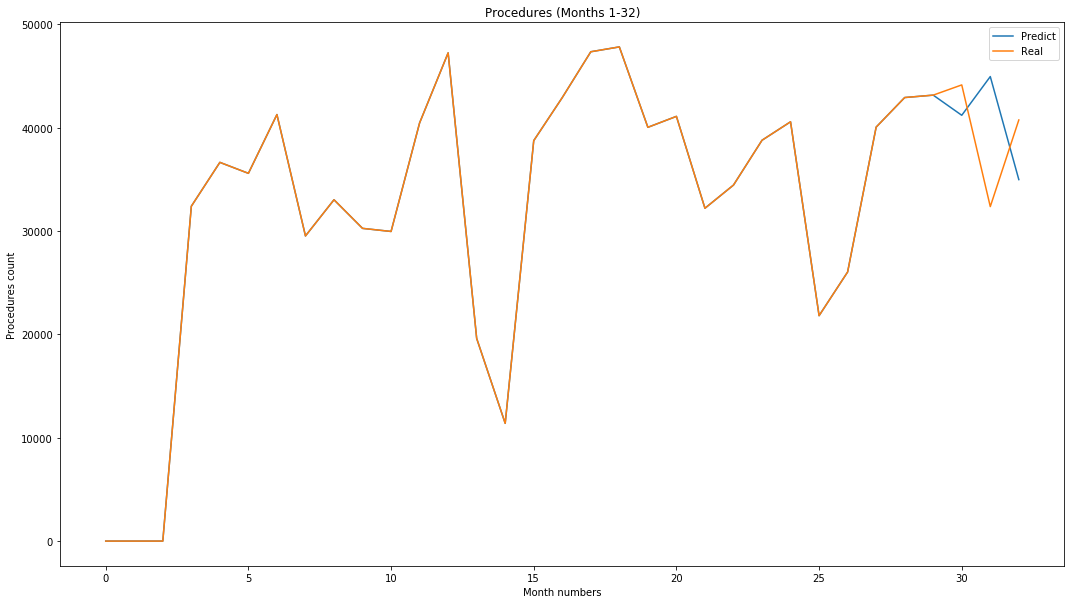

In [39]:

plt.plot(predict_ProcLR12)
plt.plot(ProcLR12)
plt.title('Procedures (Months 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

C:\Users\solod\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\solod\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


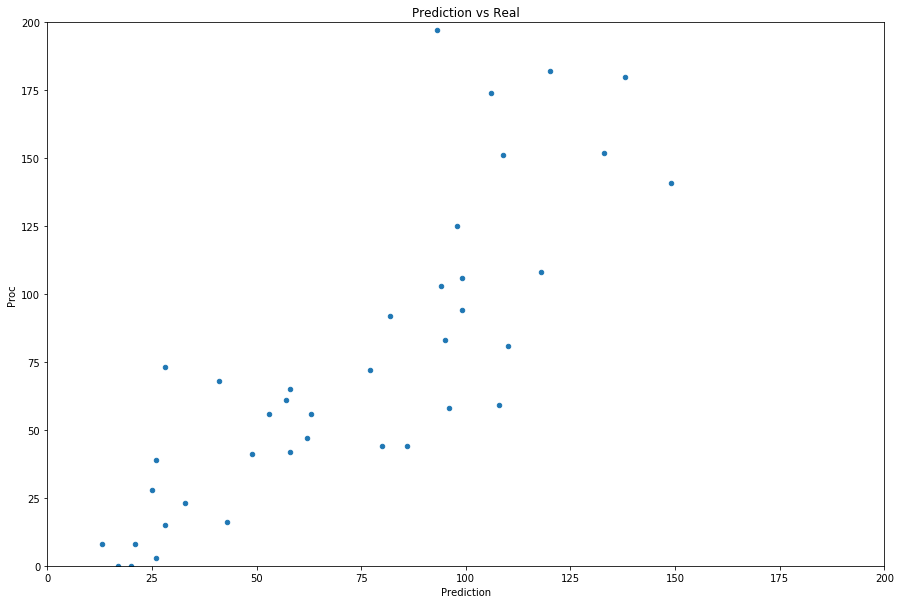

In [40]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Proc', figsize=(15,10), title='Prediction vs Real', 
                 ylim=(0,200), xlim=(0,200))

In [41]:
%%time
melt24 = melt.copy()
melt24['Last_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift()
melt24['Last_Month_Diff'] = melt24.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt24['Last-1_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-1_Month_Diff'] = melt24.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt24['Last-2_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-2_Month_Diff'] = melt24.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt24['Last-3_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-3_Month_Diff'] = melt24.groupby(['RegCode'])['Last-3_Month_Proc'].diff()
melt24['Last-4_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-4_Month_Diff'] = melt24.groupby(['RegCode'])['Last-4_Month_Proc'].diff()
melt24['Last-5_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-5_Month_Diff'] = melt24.groupby(['RegCode'])['Last-5_Month_Proc'].diff()
melt24['Last-6_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-6_Month_Diff'] = melt24.groupby(['RegCode'])['Last-6_Month_Proc'].diff()
melt24['Last-7_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-7_Month_Diff'] = melt24.groupby(['RegCode'])['Last-7_Month_Proc'].diff()
melt24['Last-8_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-8_Month_Diff'] = melt24.groupby(['RegCode'])['Last-8_Month_Proc'].diff()
melt24['Last-9_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-9_Month_Diff'] = melt24.groupby(['RegCode'])['Last-9_Month_Proc'].diff()
melt24['Last-10_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-10_Month_Diff'] = melt24.groupby(['RegCode'])['Last-10_Month_Proc'].diff()
melt24['Last-11_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-11_Month_Diff'] = melt24.groupby(['RegCode'])['Last-11_Month_Proc'].diff()
melt24['Last-12_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-12_Month_Diff'] = melt24.groupby(['RegCode'])['Last-12_Month_Proc'].diff()
melt24['Last-13_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-13_Month_Diff'] = melt24.groupby(['RegCode'])['Last-13_Month_Proc'].diff()
melt24['Last-14_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-14_Month_Diff'] = melt24.groupby(['RegCode'])['Last-14_Month_Proc'].diff()
melt24['Last-15_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-15_Month_Diff'] = melt24.groupby(['RegCode'])['Last-15_Month_Proc'].diff()
melt24['Last-16_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-16_Month_Diff'] = melt24.groupby(['RegCode'])['Last-16_Month_Proc'].diff()
melt24['Last-17_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-17_Month_Diff'] = melt24.groupby(['RegCode'])['Last-17_Month_Proc'].diff()
melt24['Last-18_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-18_Month_Diff'] = melt24.groupby(['RegCode'])['Last-18_Month_Proc'].diff()
melt24['Last-19_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-19_Month_Diff'] = melt24.groupby(['RegCode'])['Last-19_Month_Proc'].diff()
melt24['Last-20_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-20_Month_Diff'] = melt24.groupby(['RegCode'])['Last-20_Month_Proc'].diff()
melt24['Last-21_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-21_Month_Diff'] = melt24.groupby(['RegCode'])['Last-21_Month_Proc'].diff()
melt24['Last-22_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-22_Month_Diff'] = melt24.groupby(['RegCode'])['Last-22_Month_Proc'].diff()
melt24['Last-23_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-23_Month_Diff'] = melt24.groupby(['RegCode'])['Last-23_Month_Proc'].diff()
melt24['Last-24_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24 = melt24.dropna()
melt24.head()

Wall time: 320 ms


In [42]:
%%time
mean_errorRF24 = []
total_errorRF24 = []
ProcRF24 = copy.copy(procedures)
predict_ProcRF24 = copy.copy(procedures)
for Month in range(30,33):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    
    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF24.append(error)
    total_errorRF24.append(abs_error)
    ProcRF24.append(total_yts)
    predict_ProcRF24.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF24))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF24))

Month 30 - Error 0.30508, Real Total 44141.0 - Predict Total 41459.2, Abs Error 2681.8
Month 31 - Error 0.59990, Real Total 32367.0 - Predict Total 42264.5, Abs Error 9897.5
Month 32 - Error 0.50211, Real Total 40749.0 - Predict Total 34717.7, Abs Error 6031.3
Mean Error = 0.46903
Mean Abs Error = 6203.52967
Wall time: 33.9 s


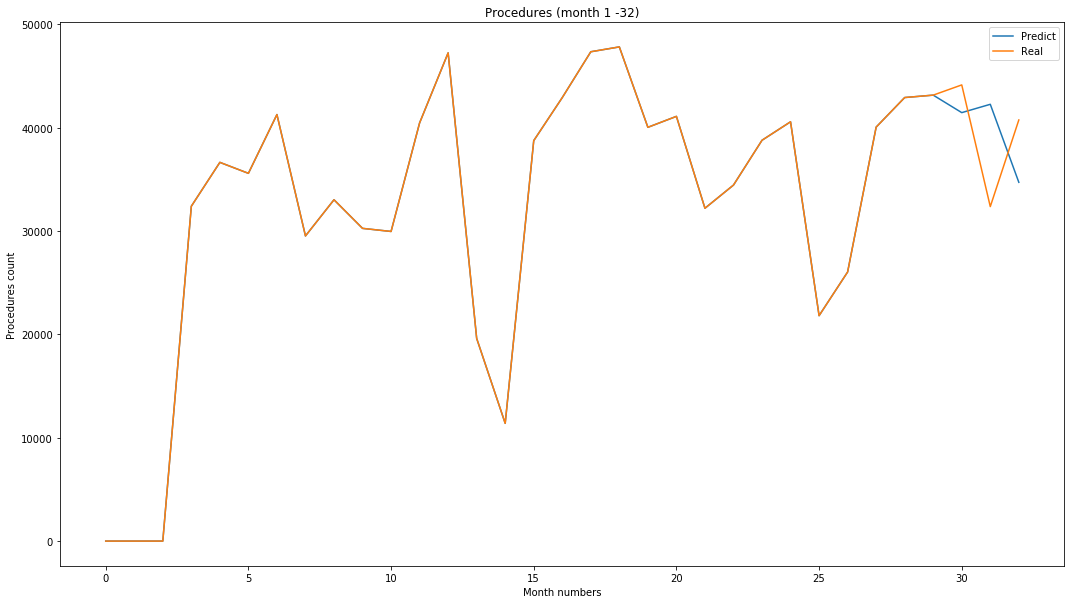

In [43]:

plt.plot(predict_ProcRF24)
plt.plot(ProcRF24)
plt.title('Procedures (month 1 -32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [44]:
%%time
mean_errorGB24 = []
total_errorGB24 = []
ProcGB24 = copy.copy(procedures)
predict_ProcGB24 = copy.copy(procedures)
for Month in range(30,33):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    
    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorGB24.append(error)
    total_errorGB24.append(abs_error)
    ProcGB24.append(total_yts)
    predict_ProcGB24.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorGB24))
print('Mean Abs Error = %.5f' % np.mean(total_errorGB24))

Month 30 - Error 0.33115, Real Total 44141.0 - Predict Total 43978.5, Abs Error 162.5
Month 31 - Error 0.60320, Real Total 32367.0 - Predict Total 44628.6, Abs Error 12261.6
Month 32 - Error 0.57268, Real Total 40749.0 - Predict Total 30449.3, Abs Error 10299.7
Mean Error = 0.50235
Mean Abs Error = 7574.58783
Wall time: 7.99 s


In [46]:
%%time
mean_errorLR24 = []
total_errorLR24 = []
ProcLR24 = copy.copy(procedures)
predict_ProcLR24 = copy.copy(procedures)
for Month in range(30,33):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorLR24.append(error)
    total_errorLR24.append(abs_error)
    ProcLR24.append(total_yts)
    predict_ProcLR24.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorLR24))
print('Mean Abs Error = %.5f' % np.mean(total_errorLR24))

Month 30 - Error 0.68292, Real Total 44141.0 - Predict Total 41202.3, Abs Error 2938.7
Month 31 - Error 0.97132, Real Total 32367.0 - Predict Total 44948.8, Abs Error 12581.8
Month 32 - Error 0.61223, Real Total 40749.0 - Predict Total 34794.8, Abs Error 5954.2
Mean Error = 0.75549
Mean Abs Error = 7158.24492
Wall time: 26.9 ms


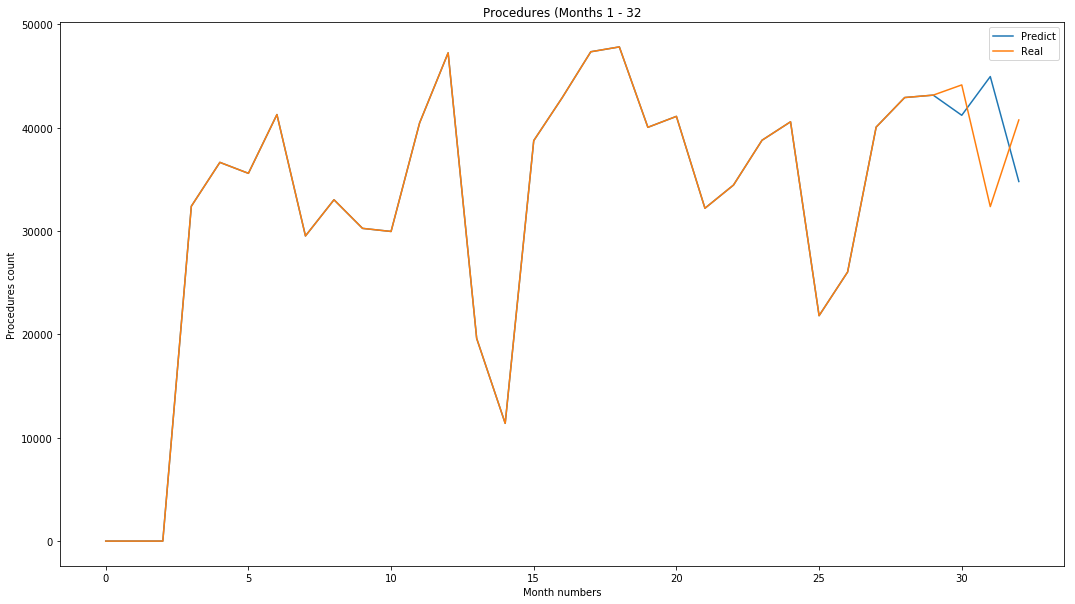

In [47]:

plt.plot(predict_ProcLR24)
plt.plot(ProcLR24)
plt.title('Procedures (Months 1 - 32')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

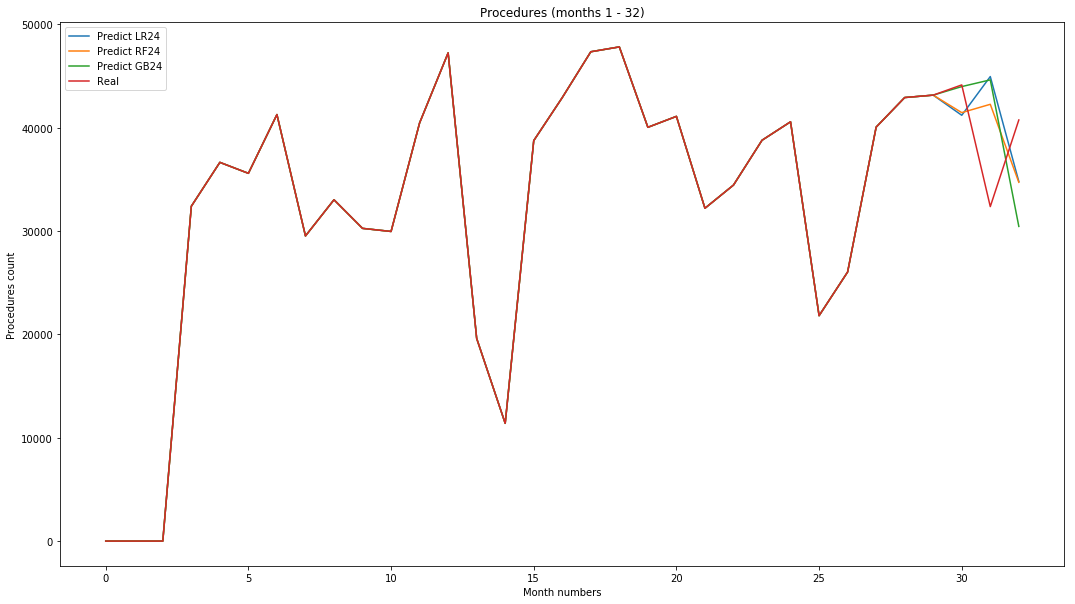

In [48]:
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(ProcGB24)

plt.title('Procedures (months 1 - 32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict LR24', 'Predict RF24', 'Predict GB24', 'Real'))

In [49]:
print('Mean Error baseline = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error baseline = %.5f' % np.mean(total_errorB))
print('Mean Error LR2 = %.5f' % np.mean(mean_error2))
print('Mean Abs Error LR2 = %.5f' % np.mean(total_error2))
print('Mean Error RF2 = %.5f' % np.mean(mean_errorRF2))
print('Mean Abs Error RF2 = %.5f' % np.mean(total_errorRF2))
print('Mean Error RF3 = %.5f' % np.mean(mean_errorRF3))
print('Mean Abs Error RF3 = %.5f' % np.mean(total_errorRF3))
print('Mean Error RF4 = %.5f' % np.mean(mean_errorRF4))
print('Mean Abs Error RF4 = %.5f' % np.mean(total_errorRF4))
print('Mean Error GB4 = %.5f' % np.mean(mean_errorGB4))
print('Mean Abs Error GB4 = %.5f' % np.mean(total_errorGB4))
print('Mean Error LR12 = %.5f' % np.mean(mean_errorLR12))
print('Mean Abs Error LR12 = %.5f' % np.mean(total_errorLR12))
print('Mean Error RF12 = %.5f' % np.mean(mean_errorRF12))
print('Mean Abs Error RF12 = %.5f' % np.mean(total_errorRF12))
print('Mean Error GB12 = %.5f' % np.mean(mean_errorGB12))
print('Mean Abs Error GB12 = %.5f' % np.mean(total_errorGB12))
print('Mean Error LR24 = %.5f' % np.mean(mean_errorLR24))
print('Mean Abs Error LR24 = %.5f' % np.mean(total_errorLR24))
print('Mean Error RF24 = %.5f' % np.mean(mean_errorRF24))
print('Mean Abs Error RF24 = %.5f' % np.mean(total_errorRF24))
print('Mean Error GB24 = %.5f' % np.mean(mean_errorGB24))
print('Mean Abs Error GB24 = %.5f' % np.mean(total_errorGB24))

Mean Error baseline = 0.45565
Mean Abs Error baseline = 7048.33333
Mean Error LR2 = 0.81404
Mean Abs Error LR2 = 6907.10937
Mean Error RF2 = 0.46765
Mean Abs Error RF2 = 5682.18267
Mean Error RF3 = 0.46806
Mean Abs Error RF3 = 6123.24067
Mean Error RF4 = 0.46855
Mean Abs Error RF4 = 6228.93967
Mean Error GB4 = 0.50235
Mean Abs Error GB4 = 7574.58783
Mean Error LR12 = 0.75367
Mean Abs Error LR12 = 7097.06960
Mean Error RF12 = 0.46939
Mean Abs Error RF12 = 6197.24700
Mean Error GB12 = 0.50235
Mean Abs Error GB12 = 7574.58783
Mean Error LR24 = 0.75549
Mean Abs Error LR24 = 7158.24492
Mean Error RF24 = 0.46903
Mean Abs Error RF24 = 6203.52967
Mean Error GB24 = 0.50235
Mean Abs Error GB24 = 7574.58783
